In [47]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import plotly.express as px
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
import joblib
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import optuna
from lightgbm import LGBMRegressor
import json




# Get the Data 

https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

## 🧹 Data Cleaning & Initial Inspection

In [48]:
df = pd.concat(
    (pd.read_csv(p) for p in glob.glob("*.csv")),
    ignore_index=True
)
df.head()

model  year  price transmission  mileage fuelType    tax   mpg  engineSize  \
0    A1  2017  12500       Manual    15735   Petrol  150.0  55.4         1.4   
1    A6  2016  16500    Automatic    36203   Diesel   20.0  64.2         2.0   
2    A1  2016  11000       Manual    29946   Petrol   30.0  55.4         1.4   
3    A4  2017  16800    Automatic    25952   Diesel  145.0  67.3         2.0   
4    A3  2019  17300       Manual     1998   Petrol  145.0  49.6         1.0   

   tax(£)  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [49]:
df.isnull().sum()/len(df)*100

model            0.000000
year             0.000000
price            0.000000
transmission     0.000000
mileage          0.000000
fuelType         0.000000
tax             13.094712
mpg              8.617100
engineSize       0.000000
tax(£)          95.522388
dtype: float64

In [50]:
df.drop(columns=['tax(£)'],inplace=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           94327 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 7.5+ MB


In [52]:
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106259 entries, 0 to 108539
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         106259 non-null  object 
 1   year          106259 non-null  int64  
 2   price         106259 non-null  int64  
 3   transmission  106259 non-null  object 
 4   mileage       106259 non-null  int64  
 5   fuelType      106259 non-null  object 
 6   tax           92938 non-null   float64
 7   mpg           97704 non-null   float64
 8   engineSize    106259 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 8.1+ MB


Summary of Data prep:
- tax(£) column dropped.
- 381 duplicates removed.
- Dataset shape: ~106k rows.

## 📊 Exploratory Data Analysis (EDA)

In [53]:
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns

In [54]:
px.box(df,'year')

2060???

In [55]:
df = df[df['year']<=2024]
px.box(df,'year')

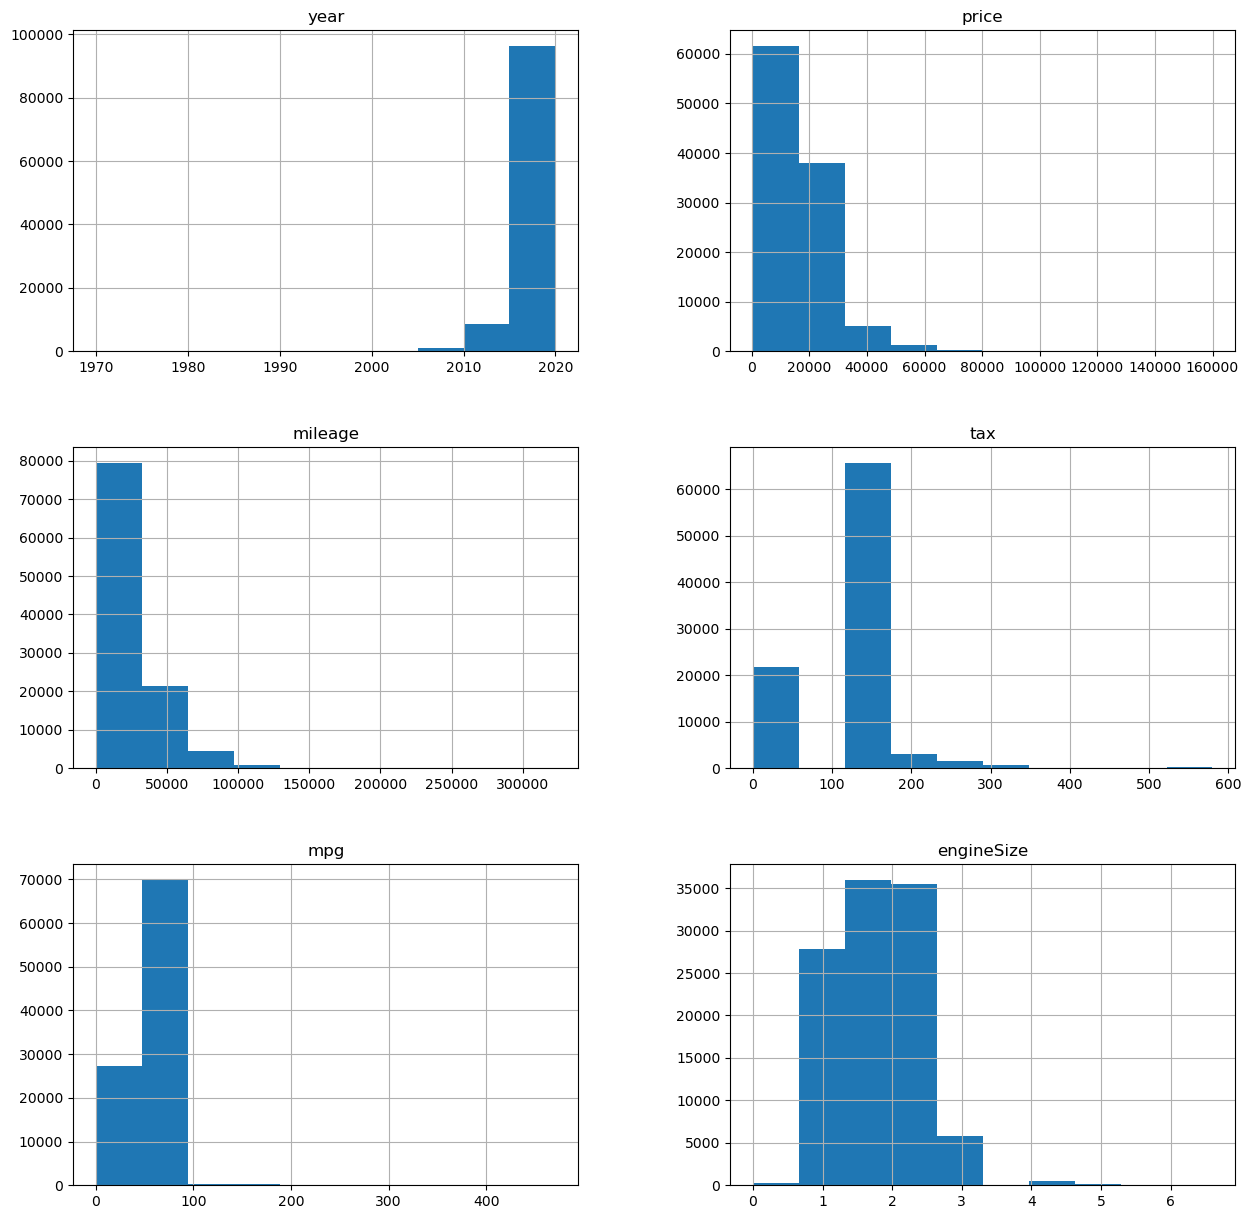

In [56]:
df[num_cols].hist(figsize=(15,15));

In [57]:
df['age'] = df['year'].max() - df['year']
df.drop(columns='year',inplace=True)
num_cols = df.select_dtypes(exclude='object').columns
df.head()

model  price transmission  mileage fuelType    tax   mpg  engineSize  age
0    A1  12500       Manual    15735   Petrol  150.0  55.4         1.4    3
1    A6  16500    Automatic    36203   Diesel   20.0  64.2         2.0    4
2    A1  11000       Manual    29946   Petrol   30.0  55.4         1.4    4
3    A4  16800    Automatic    25952   Diesel  145.0  67.3         2.0    3
4    A3  17300       Manual     1998   Petrol  145.0  49.6         1.0    1

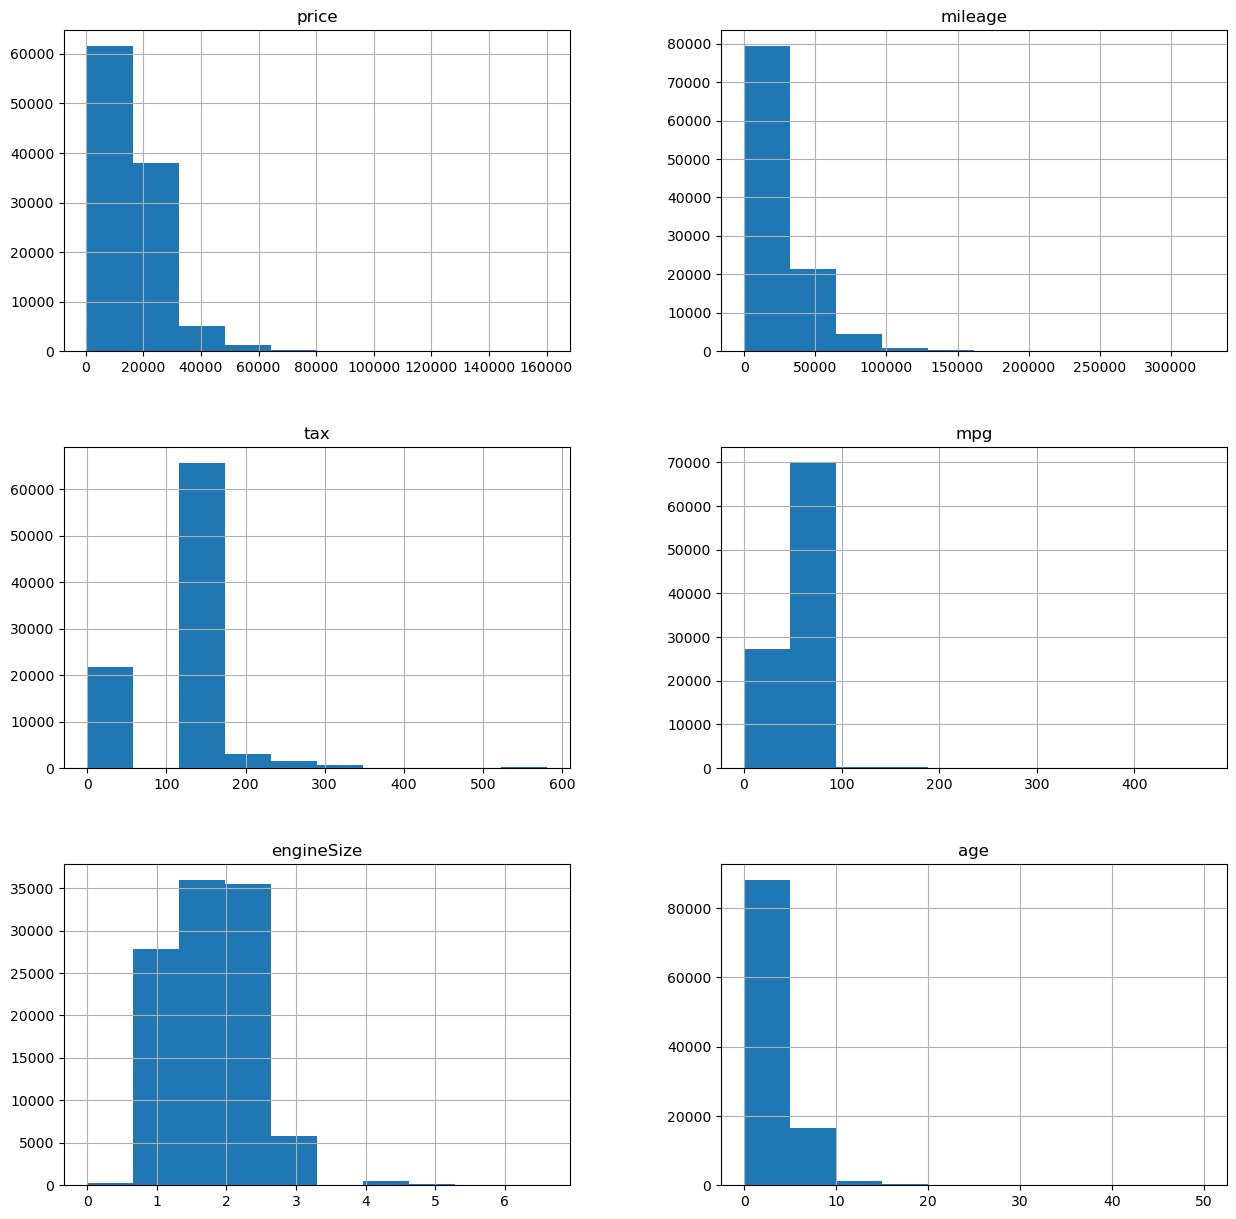

In [58]:
df[num_cols].hist(figsize=(15,15));

In [59]:
df.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])

price        mileage           tax           mpg  \
count  106258.000000  106258.000000  92937.000000  97703.000000   
mean    16863.242165   23219.836671    120.087801     55.205910   
std      9780.198901   21126.988687     63.613464     16.182086   
min       450.000000       1.000000      0.000000      0.300000   
1%       3990.000000      11.000000      0.000000     29.700000   
10%      7697.000000    2955.100000     20.000000     39.800000   
25%     10190.000000    7724.000000    125.000000     47.100000   
50%     14579.000000   17515.000000    145.000000     54.300000   
75%     20884.250000   32449.000000    145.000000     62.800000   
90%     28900.000000   50446.000000    150.000000     68.900000   
99%     51990.000000   96000.000000    265.000000     85.600000   
max    159999.000000  323000.000000    580.000000    470.800000   

          engineSize            age  
count  106258.000000  106258.000000  
mean        1.664956       2.927987  
std         0.558174       2.128103  
min         0.000000       0.000000  
1%          1.000000       0.000000  
10%         1.000000       1.000000  
25%         1.200000       1.000000  
50%         1.600000       3.000000  
75%         2.000000       4.000000  
90%         2.100000       5.000000  
99%         3.000000      11.000000  
max         6.600000      50.000000

In [60]:
df['engineSize'].replace(0.0, np.nan, inplace=True)
# Create categories
df["age_cat"] = pd.cut(df["age"],
                       bins=[-1, 1.5, 3.0, 5.0, 10.0, np.inf],
                       labels=[1, 2, 3, 4, 5])

strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, stratify=df["age_cat"], random_state=42)


print(df["age_cat"].value_counts() / len(df))
print(strat_train_set["age_cat"].value_counts() / len(strat_train_set)) # (Note: check this before dropping age_cat)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19636\2681727081.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





age_cat
2    0.360914
1    0.311722
3    0.235352
4    0.081688
5    0.010324
Name: count, dtype: float64
age_cat
2    0.360916
1    0.311719
3    0.235348
4    0.081688
5    0.010329
Name: count, dtype: float64


In [61]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_cat", axis=1, inplace=True)

## 📉 Feature Distributions
- Investigating heavy-tailed price distribution.
- Log-transformation justification.

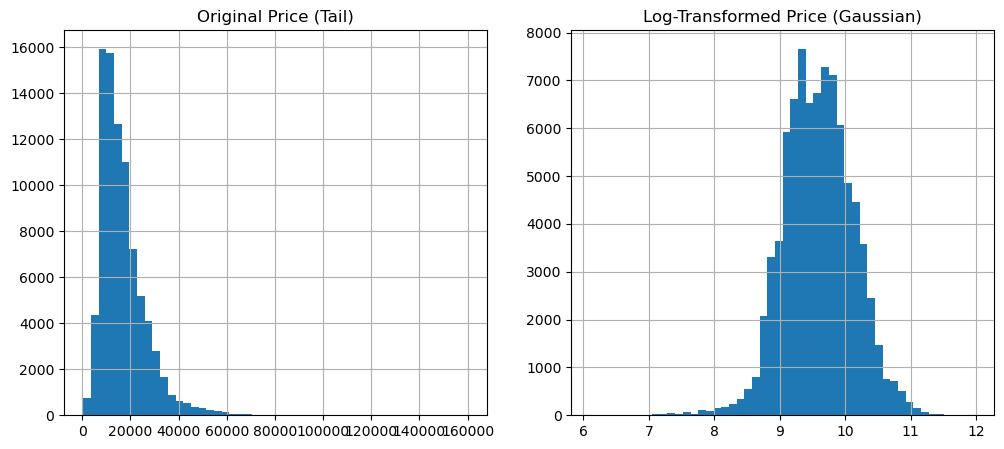

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
strat_train_set["price"].hist(bins=50)
plt.title("Original Price (Tail)")

plt.subplot(1, 2, 2)
np.log(strat_train_set["price"]).hist(bins=50)
plt.title("Log-Transformed Price (Gaussian)")

plt.show()

Indeed a heavy tailed so I applied the log function

# relationships between features visualized 

In [63]:
corr_matrix = strat_train_set.corr(numeric_only=True)
print(corr_matrix["price"].sort_values(ascending=False))

price         1.000000
engineSize    0.642347
tax           0.308677
mpg          -0.295283
mileage      -0.428165
age          -0.500420
Name: price, dtype: float64


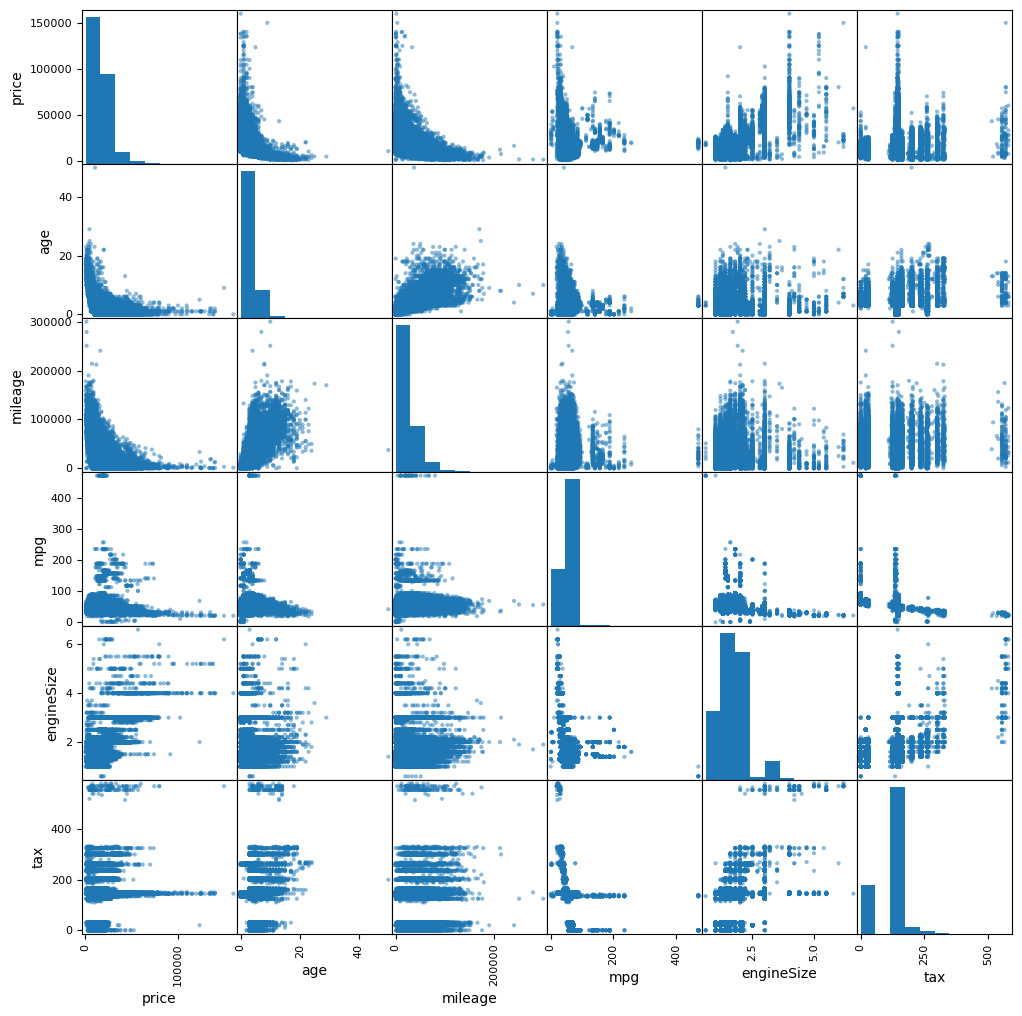

In [64]:
attributes = ["price", "age", "mileage", "mpg", "engineSize",'tax']
pd.plotting.scatter_matrix(strat_train_set[attributes], figsize=(12, 12))
plt.show()

In [65]:
fig = px.box(
    data_frame=strat_train_set,
    x="fuelType",
    y="price",
    title="Price Range by Fuel Type"
)

fig.show()


Summary of EDA findings (correlations, distributions).

## 🔍 Observations & Insights

### 1. Target Distribution: Price
- **Observation:** The `price` attribute is heavily right-tailed (skewed).
- **Impact:** Machine learning algorithms (especially Linear Regression) generally perform better when the target and features have a Gaussian (normal) distribution.
- **Action Plan:** - Apply a **Log Transformation** to the price target during the training phase.
  - Use `TransformedTargetRegressor` to ensure predictions are automatically converted back to the original scale (USD/GBP).

### 2. Feature-Target Relationship
- **Mileage vs Price:** Shows a non-linear decay.
- **Engine Size:** Contains 0.0 values which need to be treated as missing data (`NaN`) and imputed with the median.

In [66]:
# 1. Mileage per Year
# Adding 1 to age to avoid division by zero for brand-new cars
strat_train_set["mileage_per_year"] = strat_train_set["mileage"] / (strat_train_set["age"] + 1)

# 2. Engine Efficiency
strat_train_set["mpg_per_engine"] = strat_train_set["mpg"] / (strat_train_set["engineSize"] + 0.1)

In [67]:
corr_matrix = strat_train_set.corr(numeric_only=True)
print(corr_matrix["price"].sort_values(ascending=False))

price               1.000000
engineSize          0.642347
tax                 0.308677
mpg                -0.295283
mileage_per_year   -0.302017
mileage            -0.428165
age                -0.500420
mpg_per_engine     -0.526292
Name: price, dtype: float64


Removing Outliers

## 🛠️ Feature Engineering
- Handling outliers using IQR (Interquartile Range).

In [68]:
def cap_outliers_iqr(df, cols, k=1.5):
    df = df.copy()
    bounds = {}

    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        low = q1 - k * iqr
        high = q3 + k * iqr
        df[c] = df[c].clip(lower=low, upper=high)
        bounds[c] = (low, high)

    return df, bounds

# numeric features except target
num_cols = strat_train_set.select_dtypes(exclude=object).columns.tolist()
num_cols.remove('price')
num_cols.remove('age')
num_cols.remove('engineSize')
train_capped, outlier_bounds = cap_outliers_iqr(strat_train_set, num_cols, k=1.5)


In [69]:
strat_train_set = strat_train_set[strat_train_set['age']<40]

In [70]:
strat_train_set[num_cols] = train_capped[num_cols]

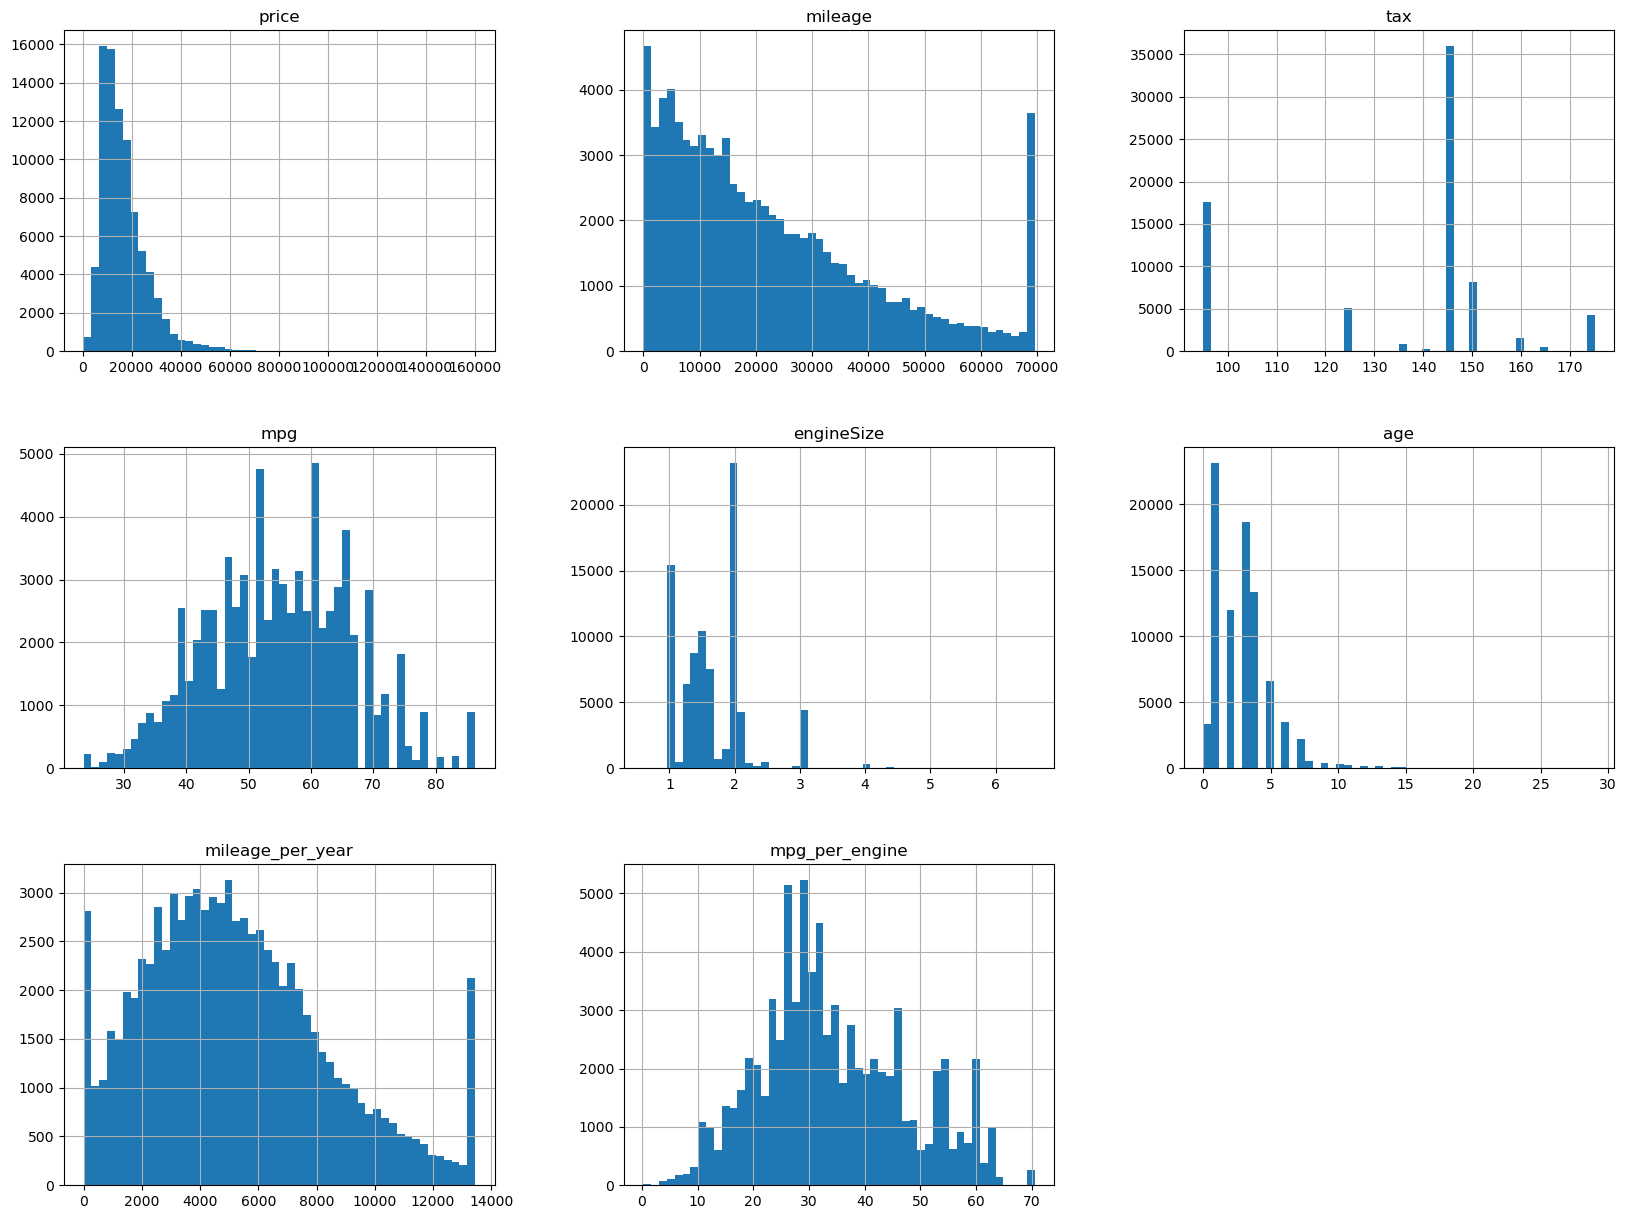

In [71]:
strat_train_set.hist(bins=50, figsize=(20, 15));

In [72]:
X_train = strat_train_set.drop("price", axis=1)
X_train.drop(columns=['mpg_per_engine', 'mileage_per_year'], inplace=True)
y_train = strat_train_set["price"].copy()

num_features = ["age", "mpg", "engineSize", 'mileage'] # remove "tax",  
cat_features = ["model", "transmission", "fuelType"]


def column_ratio(X):
    return X[:, [0]] / (X[:, [1]] + 0.1) # Added 0.1 to avoid dividing by 0

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] 

ratio_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
)


# log Pipeline (for heavy-tailed features like mileage)
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"), # Safer than np.log
    StandardScaler()
)

# Categorical & Default Numerical Pipelines
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore",sparse_output=False)
)



cat_pipeline_for_boosting = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)


num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

num_pipeline_for_boosting = make_pipeline(
    SimpleImputer(strategy="median")
)

# 5. The Master ColumnTransformer
preprocessing = ColumnTransformer([
    	("mileage_per_year", ratio_pipeline, ["mileage", "age"]),
        ("mpg_per_engine", ratio_pipeline, ["mpg", "engineSize"]),
        ("log", log_pipeline, ['mileage']),
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ]
                                  )
preprocessing_for_boosting = ColumnTransformer([
    	("mileage_per_year", ratio_pipeline, ["mileage", "age"]),
        ("mpg_per_engine", ratio_pipeline, ["mpg", "engineSize"]),
        ("num", num_pipeline_for_boosting, num_features),
        ("cat", cat_pipeline_for_boosting, cat_features),
    ]
                                  )
# 6. Prepare the Target (Handling the heavy-tailed Price!)
ridge_model = TransformedTargetRegressor(
    regressor=Ridge(random_state=42),
    func=np.log1p,
    inverse_func=np.expm1
)

# 7. Create the Ultimate End-to-End Pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", ridge_model)
])

param_grid = {
    "model__regressor__alpha": [0.01, 0.001, 0.05, 0.005]
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


print("Best alpha:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Best alpha: {'model__regressor__alpha': 0.05}
Best RMSE: 2789.088215601774


In [73]:
print("R2:", grid_search.best_estimator_.score(strat_test_set.drop("price", axis=1), strat_test_set["price"]))

best_model = grid_search.best_estimator_

# Access fitted Ridge inside TransformedTargetRegressor
ridge = best_model.named_steps["model"].regressor_

# Get feature names after preprocessing
feature_names = best_model.named_steps["preprocessing"].get_feature_names_out()

# Get coefficients
coefficients = ridge.coef_


importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(by="coefficient", key=abs, ascending=False)

print(importance_df.head(20))


R2: 0.9111799718097049
                    feature  coefficient
195          cat__model_ i8     1.059920
71      cat__model_ G Class     1.019877
173      cat__model_ Vectra    -1.014432
190          cat__model_ Z3     0.915758
52   cat__model_ California     0.855182
28        cat__model_ Amica    -0.828768
69          cat__model_ Fox    -0.798221
177        cat__model_ Viva    -0.757790
65       cat__model_ Escort     0.753915
186          cat__model_ X7     0.723234
99           cat__model_ KA    -0.680705
131          cat__model_ R8     0.661913
100         cat__model_ Ka+    -0.634165
56       cat__model_ Citigo    -0.631950
88          cat__model_ I10    -0.628674
110          cat__model_ M3     0.620610
70       cat__model_ Fusion    -0.617288
54    cat__model_ Caravelle     0.616292
161       cat__model_ Tigra    -0.610608
35         cat__model_ Aygo    -0.589654


In [74]:
X_test,y_test = strat_test_set.drop("price", axis=1), strat_test_set["price"]

importance_df[importance_df['feature'].str.contains("age|mpg|engineSize|tax|mileage")]


feature  coefficient
3                 num__age    -0.235859
5          num__engineSize     0.157053
6             num__mileage    -0.097379
1    mpg_per_engine__ratio     0.033221
4                 num__mpg    -0.029098
0  mileage_per_year__ratio    -0.005519
2             log__mileage    -0.004536

##  First Evaluation
- **Model:** Ridge Regression (Regularized Linear)
- **Best Hyperparameter:** alpha = 0.005
- **Performance (Test Set):** $R^2 = 0.878$
- **RMSE:** £2,369
- **Conclusion:** The model is robust and generalizes well. The log-transformation of price was critical in handling the skewed distribution of high-end vehicle prices.

In [75]:
def _rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    results = {}

    # Always compute real-space metrics
    results["RMSE_real"] = _rmse(y_test, y_pred)
    results["MAE_real"] = mean_absolute_error(y_test, y_pred)
    results["R2_real"] = r2_score(y_test, y_pred)

    return results


In [76]:
RANDOM_SEED = 42

linear_models = {
    "Ridge_log": Ridge(alpha= 0.005, random_state=RANDOM_SEED),
    "ElasticNet_log": ElasticNet(
        alpha=0.01,
        l1_ratio=0.3,
        max_iter=50000,
        random_state=RANDOM_SEED
    ),
}

tree_models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_SEED
    ),

    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_iter=500,
        learning_rate=0.05,
        random_state=RANDOM_SEED
    ),

    "XGBoost": XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=RANDOM_SEED
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED
    ),
}


In [77]:
results = []
for name, reg in linear_models.items():

    pipe = Pipeline([
        ("preprocessing", preprocessing),
        ("model", TransformedTargetRegressor(
            regressor=reg,
            func=np.log1p,
            inverse_func=np.expm1
        ))
    ])

    metrics = evaluate_model(pipe, X_train, X_test, y_train, y_test)
    metrics["Model"] = name
    results.append(metrics)

for name, reg in tree_models.items():

    pipe = Pipeline([
        ("preprocessing", preprocessing_for_boosting),
        ("model", reg)
    ])

    metrics = evaluate_model(pipe, X_train, X_test, y_train, y_test)
    metrics["Model"] = name
    results.append(metrics)

results_df = pd.DataFrame(results).sort_values("RMSE_real")
results_df


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



RMSE_real     MAE_real   R2_real                 Model
5  2032.730410  1203.969891  0.957091              LightGBM
4  2060.294032  1279.875977  0.955920               XGBoost
3  2161.625463  1319.450972  0.951477  HistGradientBoosting
2  2290.528199  1233.590935  0.945518          RandomForest
0  2924.631418  1668.159970  0.911177             Ridge_log
1  4283.925054  2683.743834  0.809424        ElasticNet_log

## 🚀 Optimization Phase: Boosting Specialization
- **Strategy:** Developed separate preprocessing streams for Linear vs. Boosting models.
- **Key Change:** Implemented `OrdinalEncoder` for Tree-based models to preserve feature density.
- **Current Benchmark:** LightGBM achieved $R^2 = 0.956$, a significant improvement over previous iterations.
- **Next Step:** Executing a 50-iteration `RandomizedSearchCV` to fine-tune tree depth and learning rates.

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

param_dist = {
    "model__n_estimators": randint(800, 1800),
    "model__learning_rate": uniform(0.02, 0.08),
    "model__num_leaves": randint(31, 120),
    "model__min_child_samples": randint(15, 60),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__reg_alpha": uniform(0.0, 1.0),
    "model__reg_lambda": uniform(0.0, 1.0),
}

boosting_pipeline = Pipeline([
    ("preprocessing", preprocessing_for_boosting),
    ("model", LGBMRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=-1
))])


rnd_search = RandomizedSearchCV(
    boosting_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rnd_search.fit(X_train, y_train)
print("Best CV RMSE:", -rnd_search.best_score_)
print("Best Params:", rnd_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV RMSE: 1883.1897219635732
Best Params: {'model__colsample_bytree': np.float64(0.6560336060946096), 'model__learning_rate': np.float64(0.061466372189098936), 'model__min_child_samples': 16, 'model__n_estimators': 1785, 'model__num_leaves': 47, 'model__reg_alpha': np.float64(0.8486697949246744), 'model__reg_lambda': np.float64(0.13662133144202881), 'model__subsample': np.float64(0.8835643987640474)}


In [79]:
# 1. Get the best estimator from your search
final_model = rnd_search.best_estimator_

# 2. Predict on the TEST set (the data the model has never seen)
y_test_pred = final_model.predict(strat_test_set.drop("price", axis=1))
y_test_true = strat_test_set["price"]

# 3. Calculate final metrics
final_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
final_r2 = r2_score(y_test_true, y_test_pred)

print(f"Final Test RMSE: £{final_rmse:.2f}")
print(f"Final Test R2: {final_r2:.4f}")

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Final Test RMSE: £1965.64
Final Test R2: 0.9599


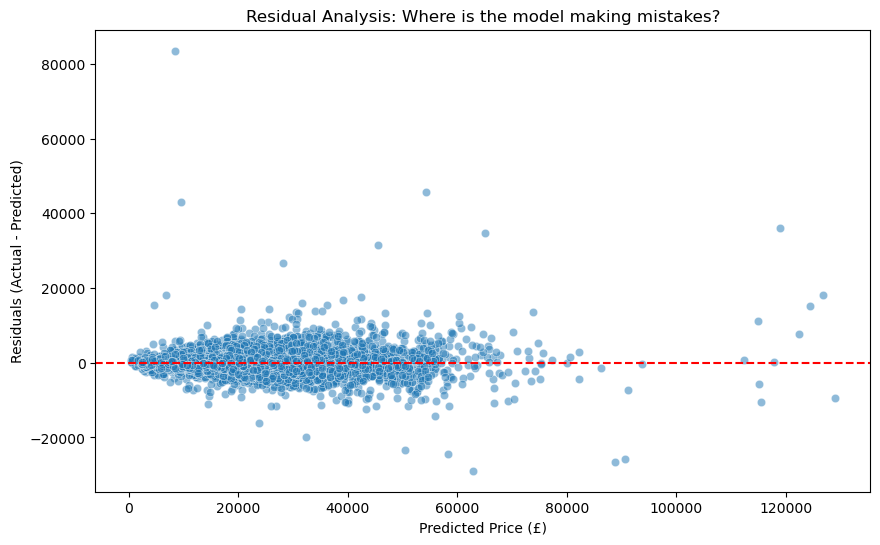

In [80]:
residuals = y_test_true - y_test_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (£)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Analysis: Where is the model making mistakes?")
plt.show()

In [81]:
# 1. Create a DataFrame for analysis
analysis_df = strat_test_set.copy()
analysis_df["predicted_price"] = y_test_pred
analysis_df["error"] = analysis_df["price"] - analysis_df["predicted_price"]
analysis_df["abs_error"] = analysis_df["error"].abs()

# 2. Sort by absolute error to find the biggest "misses"
biggest_fails = analysis_df.sort_values(by="abs_error", ascending=False).head(5)

# 3. Display the details of these 5 cars
print(biggest_fails[['model', 'age', 'mileage', 'engineSize', 'price', 'predicted_price', 'error']])

          model  age  mileage  engineSize   price  predicted_price  \
53014       I10    3    35460         1.2   92000      8475.968101   
16030        M4    4      771         3.0   99950     54303.025244   
86793     Mokka    4    52489         1.6   52489      9515.295423   
63671   G Class    0     3000         4.0  154998    118917.567916   
59289   G Class    5    10000         5.5   99850     65066.448432   

              error  
53014  83524.031899  
16030  45646.974756  
86793  42973.704577  
63671  36080.432084  
59289  34783.551568  


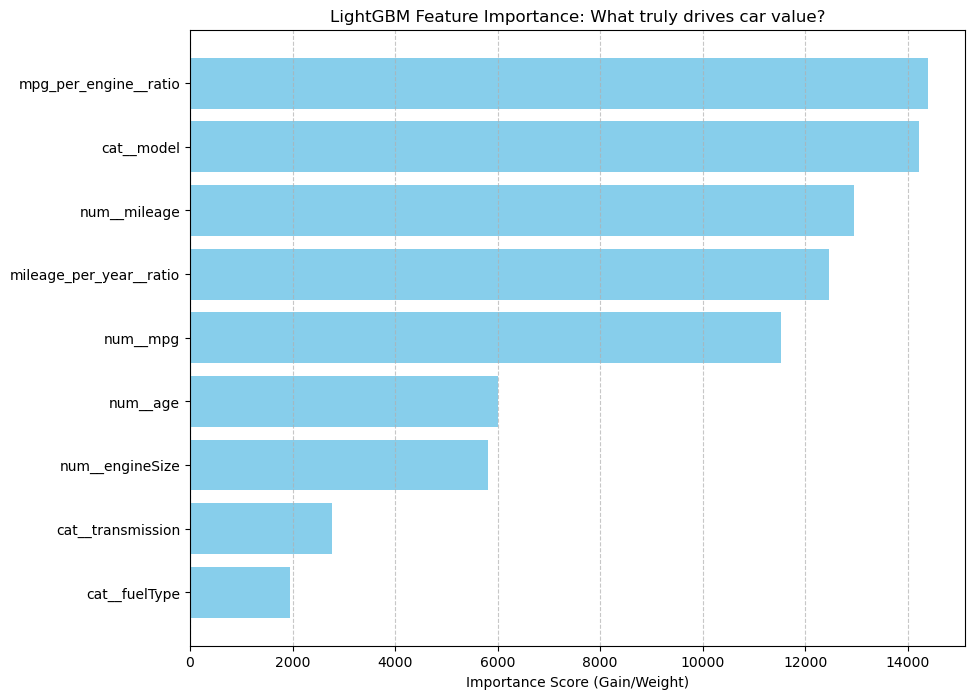

In [82]:
# 1. Access the model directly from the pipeline steps
# Since LightGBM wasn't wrapped in TransformedTargetRegressor in your tree loop
lgbm_final = final_model.named_steps["model"]

# 2. Extract importances
importances = lgbm_final.feature_importances_

# 3. Get the feature names from the preprocessing step
feature_names = final_model.named_steps["preprocessing"].get_feature_names_out()

# 4. Plotting the top 15
plt.figure(figsize=(10, 8))
sorted_idx = np.argsort(importances)
plt.barh(range(len(sorted_idx))[-15:], importances[sorted_idx][-15:], color='skyblue')
plt.yticks(range(len(sorted_idx))[-15:], [feature_names[i] for i in sorted_idx][-15:])
plt.title("LightGBM Feature Importance: What truly drives car value?")
plt.xlabel("Importance Score (Gain/Weight)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 🧠 Advanced Hyperparameter Tuning with Optuna

In this section, we implement **Optuna** for intelligent hyperparameter optimization of our LightGBM model. Unlike traditional grid or random search, Optuna uses Bayesian optimization to efficiently navigate the hyperparameter space.

## 🎯 Optimization Strategy

Optuna's approach is fundamentally different from conventional methods. Instead of randomly testing combinations, it:

- **Builds a probabilistic model** of the objective function
- **Selects promising hyperparameters** based on previous trial performance
- **Focuses computational resources** on the most promising regions of the parameter space

## 🔧 Key Features

| Feature | Description | Benefit |
|---------|-------------|---------|
| **Bayesian Search** | Learns from previous trials to guide the search | Converges faster to optimal regions |
| **Automatic Pruning** | Terminates poor-performing trials early | Saves computational resources |
| **Intelligent Sampling** | Balances exploration vs. exploitation | Finds better local optima |

## 📊 Method Comparison

| Method | Strategy | Best For |
|--------|----------|----------|
| **Random Search** | Random selection from parameter space | Baseline tuning & exploring wide ranges |
| **Grid Search** | Exhaustive search over predefined grid | Small parameter spaces |
| **Optuna** | Bayesian optimization | Deep optimization & squeezing out final performance |

## ⚡ Why Optuna for This Project?

Optuna's ability to **prune underperforming trials** makes it particularly valuable for LightGBM tuning, where training time can be significant. By focusing computational resources on promising hyperparameter combinations, we can explore more options in less time.

In [90]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 800, 1800),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 60),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }

    model = LGBMRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        **params
    )

    pipe = Pipeline([
        ("preprocessing", preprocessing_for_boosting),
        ("model", model)
    ])

    score = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring="r2",
        n_jobs=-1
    )

    return score.mean()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2026-02-19 06:45:41,008] A new study created in memory with name: no-name-3df427db-4be4-4ff2-b0d3-3407b6616574
[I 2026-02-19 06:47:13,394] Trial 0 finished with value: 0.9619571722775723 and parameters: {'n_estimators': 1582, 'learning_rate': 0.03207598471918326, 'num_leaves': 89, 'min_child_samples': 19, 'subsample': 0.8509063709097107, 'colsample_bytree': 0.9636255201479648, 'reg_alpha': 0.15991460856681083, 'reg_lambda': 0.744934683982087}. Best is trial 0 with value: 0.9619571722775723.
[I 2026-02-19 06:48:08,809] Trial 1 finished with value: 0.9609804978617283 and parameters: {'n_estimators': 1772, 'learning_rate': 0.061866104623881035, 'num_leaves': 70, 'min_child_samples': 60, 'subsample': 0.7422232843058976, 'colsample_bytree': 0.6738164329219615, 'reg_alpha': 0.33918390419480615, 'reg_lambda': 0.7086139490661136}. Best is trial 0 with value: 0.9619571722775723.
[I 2026-02-19 06:48:52,544] Trial 2 finished with value: 0.9617477901590249 and parameters: {'n_estimators': 844, 

In [99]:
optuna.visualization.plot_optimization_history(study)


In [100]:
optuna.visualization.plot_param_importances(study)

In [ ]:
print("Best R2:", study.best_value)
print("Best Params:", study.best_params)

Best RMSE: 0.9630624665926593
Best Params: {'n_estimators': 1565, 'learning_rate': 0.02469133049411534, 'num_leaves': 143, 'min_child_samples': 10, 'subsample': 0.9813319337719706, 'colsample_bytree': 0.6980855200325209, 'reg_alpha': 0.05115536524547326, 'reg_lambda': 0.8465422923644881}


🚀 Training final model with best hyperparameters...


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names




📊 MODEL PERFORMANCE REPORT

🎯 Test Set Metrics:
   R² Score:        0.9601
   Adjusted R²:     0.9601
   RMSE:            £1,960.89
   MAE:             £1,135.90
   MAPE:            7.16%

⚙️  Best Hyperparameters (from Optuna):
----------------------------------------
   n_estimators        : 1565
   learning_rate       : 0.02469133049411534
   num_leaves          : 143
   min_child_samples   : 10
   subsample           : 0.9813319337719706
   colsample_bytree    : 0.6980855200325209
   reg_alpha           : 0.05115536524547326
   reg_lambda          : 0.8465422923644881

📈 Optimization Best Value (R²): 0.963062
   Note: This was the CV R² score during optimization

🔍 Cross-validation vs Test Set:
   CV R²:     0.963062
   Test R²:   0.960071
   Difference: 0.002992
   ✅ Model generalizes well! (Small difference)


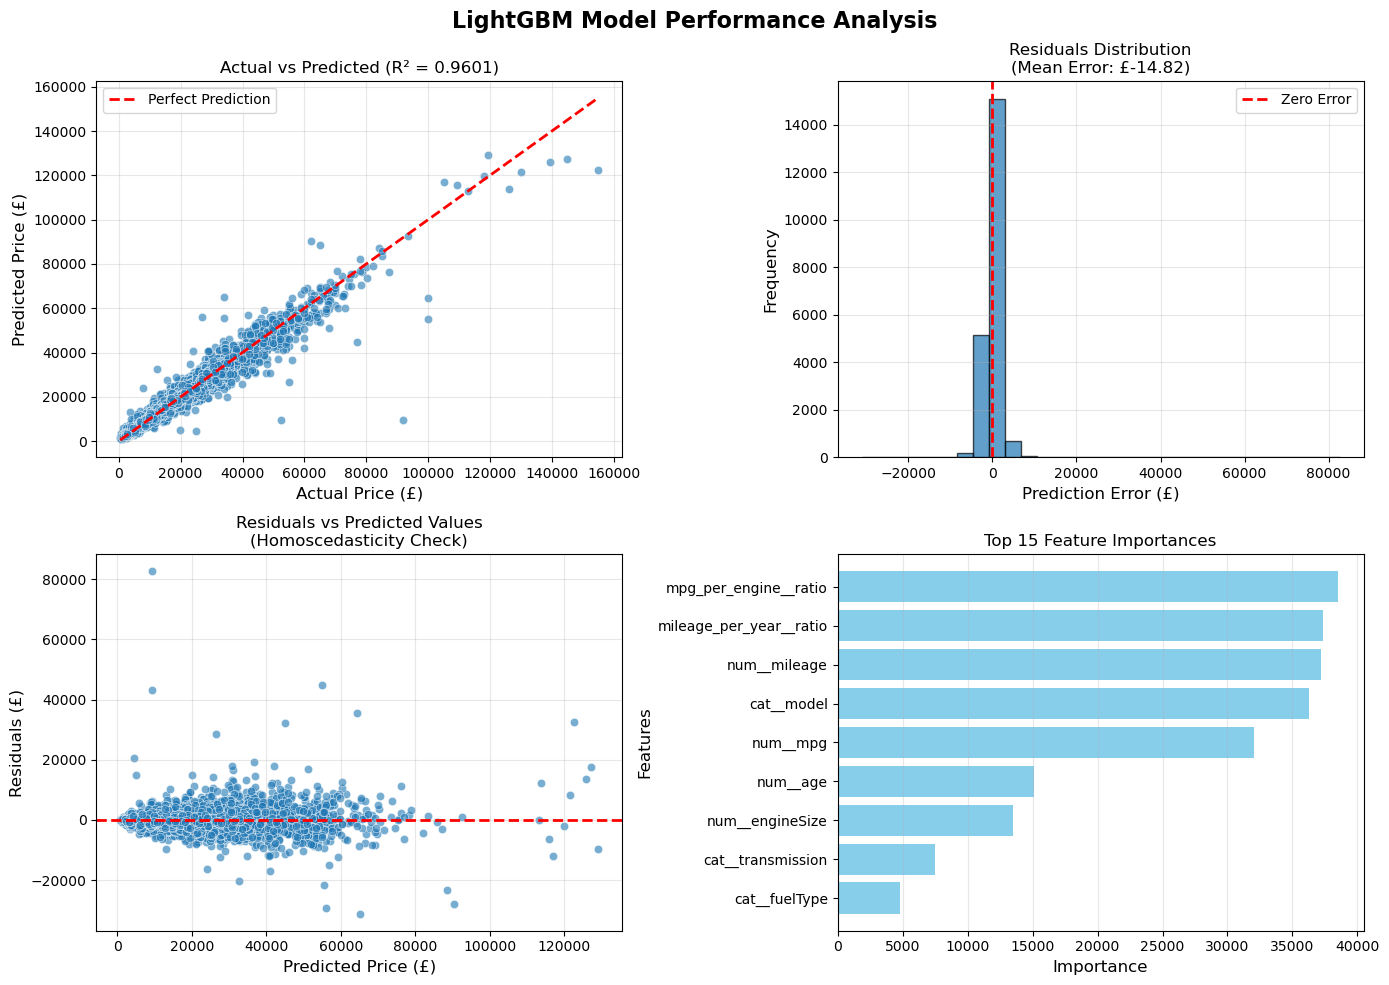


📋 QUICK SUMMARY:
   Best CV R² from Optuna:  0.963062
   Test Set R²:             0.960071
   Test Set RMSE:           £1,960.89
   Test Set MAE:            £1,135.90


In [ ]:
# Train final model with best parameters
print("🚀 Training final model with best hyperparameters...")
print("="*60)

best_model = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    **study.best_params
)

# Create pipeline
pipe = Pipeline([
    ("preprocessing", preprocessing_for_boosting),
    ("model", best_model)
])

# Train on full training data
pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error) with handling for zero values
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    n = len(y_true)
    p = len(study.best_params)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan
    
    return {
        'R²': r2,
        'Adjusted R²': adj_r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': f"{mape:.2f}%" if not np.isnan(mape) else "N/A"
    }

metrics = calculate_metrics(y_test, y_pred)

print("\n📊 MODEL PERFORMANCE REPORT")
print("="*60)
print(f"\n🎯 Test Set Metrics:")
print(f"   R² Score:        {metrics['R²']:.4f}")
print(f"   Adjusted R²:     {metrics['Adjusted R²']:.4f}")
print(f"   RMSE:            £{metrics['RMSE']:,.2f}")
print(f"   MAE:             £{metrics['MAE']:,.2f}")
print(f"   MAPE:            {metrics['MAPE']}")

print(f"\n⚙️  Best Hyperparameters (from Optuna):")
print("-"*40)
for param, value in study.best_params.items():
    print(f"   {param:20s}: {value}")

print(f"\n📈 Optimization Best Value (R²): {study.best_value:.6f}")
print(f"   Note: This was the CV R² score during optimization")

r2_diff = abs(study.best_value - metrics['R²'])
print(f"\n🔍 Cross-validation vs Test Set:")
print(f"   CV R²:     {study.best_value:.6f}")
print(f"   Test R²:   {metrics['R²']:.6f}")
print(f"   Difference: {r2_diff:.6f}")

if r2_diff < 0.01:
    print("   ✅ Model generalizes well! (Small difference)")
elif r2_diff < 0.02:
    print("   ⚠️  Moderate difference - model might be slightly overfitting")
else:
    print("   ❌ Large difference - model may be overfitting")

# Suppress the feature name warning (optional)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('LightGBM Model Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (£)', fontsize=12)
ax1.set_ylabel('Predicted Price (£)', fontsize=12)
ax1.set_title(f'Actual vs Predicted (R² = {metrics["R²"]:.4f})', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals Distribution
ax2 = axes[0, 1]
residuals = y_test - y_pred
ax2.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax2.set_xlabel('Prediction Error (£)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Residuals Distribution\n(Mean Error: £{residuals.mean():.2f})', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_pred, residuals, alpha=0.6, edgecolors='w', linewidth=0.5)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Price (£)', fontsize=12)
ax3.set_ylabel('Residuals (£)', fontsize=12)
ax3.set_title('Residuals vs Predicted Values\n(Homoscedasticity Check)', fontsize=12)
ax3.grid(True, alpha=0.3)


# Plot 4: Feature Importance
ax4 = axes[1, 1]
try:
    # Try to get feature names from preprocessor
    if hasattr(preprocessing_for_boosting, 'get_feature_names_out'):
        feature_names = preprocessing_for_boosting.get_feature_names_out()
    else:
        # Fallback feature names
        feature_names = [f'Feature_{i}' for i in range(len(best_model.feature_importances_))]
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    ax4.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    ax4.set_xlabel('Importance', fontsize=12)
    ax4.set_ylabel('Features', fontsize=12)
    ax4.set_title('Top 15 Feature Importances', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='x')
except Exception as e:
    # Fallback if feature names aren't available
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]
    ax4.barh(range(len(indices)), importances[indices], color='skyblue')
    ax4.set_yticks(range(len(indices)))
    ax4.set_yticklabels([f'Feature {i}' for i in indices])
    ax4.set_xlabel('Importance', fontsize=12)
    ax4.set_title('Top 15 Feature Importances', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n📋 QUICK SUMMARY:")
print("="*60)
print(f"   Best CV R² from Optuna:  {study.best_value:.6f}")
print(f"   Test Set R²:             {metrics['R²']:.6f}")
print(f"   Test Set RMSE:           £{metrics['RMSE']:,.2f}")
print(f"   Test Set MAE:            £{metrics['MAE']:,.2f}")

In [1]:
ax3.savefig("residuals_vs_predicted.png")

NameError: name 'ax3' is not defined

In [105]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# 1. YOU MUST REDEFINE THE CUSTOM FUNCTIONS HERE
# The model needs to "see" these definitions to unpickle correctly
def column_ratio(X):
    return X[:, [0]] / (X[:, [1]] + 0.1)

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

# 1. Load the saved pipeline
model = joblib.load('car_price_predictor_pipeline.pkl')

# 2. App Title and Description
st.title("🏎️ Audi Price Predictor")
st.markdown("Enter the vehicle details below to get an instant market valuation.")

# 3. Create Input Layout
col1, col2 = st.columns(2)

with col1:
    model_name = st.selectbox("Car Model", [" A1", " A3", " A4", " A6", " Q3", " Q5", " Q7", " TT"])
    year = st.number_input("Year of Manufacture", min_value=1997, max_value=2024, value=2018)
    transmission = st.selectbox("Transmission", ["Manual", "Semi-Auto", "Automatic"])
    fuelType = st.selectbox("Fuel Type", ["Petrol", "Diesel", "Hybrid"])

with col2:
    mileage = st.number_input("Mileage", min_value=0, value=30000)
    tax = st.number_input("Annual Tax (£)", min_value=0, value=145)
    mpg = st.number_input("MPG", min_value=0.0, value=55.0)
    engineSize = st.number_input("Engine Size (L)", min_value=0.0, value=2.0)

# 4. Calculation Logic
if st.button("Calculate Valuation"):
    # Create the DataFrame (matching your training structure)
    input_data = pd.DataFrame([{
        'model': model_name,
        'year': year,
        'age': 2024 - year, # Age calculation
        'transmission': transmission,
        'mileage': mileage,
        'fuelType': fuelType,
        'tax': tax,
        'mpg': mpg,
        'engineSize': engineSize
    }])
    
    # Predict
    prediction = model.predict(input_data)[0]
    
    # Output Result
    st.success(f"### Estimated Value: £{prediction:,.2f}")
    st.info("Note: This estimate is based on historical Audi market data (~96% accuracy).")

Overwriting app.py


In [106]:
! streamlit run app.py

^C


# 🏎️ Audi Used Car Price Predictor

This project implements a high-precision Machine Learning pipeline to estimate the market value of used Audi vehicles. By leveraging **Gradient Boosting (LightGBM)** and custom feature engineering, the model achieves a high degree of accuracy, explaining **~96%** of the price variance.



## 📊 Performance Summary
* **R² Score:** 0.9601
* **MAE (Mean Absolute Error):** £1,135.90
* **MAPE (Relative Error):** 7.16%
* **Best Model:** LightGBM (Tuned via Optuna)

---

## 🛠️ The Pipeline
The project utilizes a specialized dual-stream `ColumnTransformer` to handle different model requirements, ensuring maximum accuracy for tree-based architectures.

### 1. Feature Engineering
Created synthetic features to capture car wear and efficiency:
* **`mileage_per_year`**: Captures how aggressively the car was driven.
* **`mpg_per_engine`**: Measures fuel efficiency relative to power.
* **`age`**: Derived from the year of manufacture.

### 2. Preprocessing Streams
* **Boosting Stream:** SimpleImputer (Median) ➔ **OrdinalEncoder** (for non-linear efficiency).
* **Final Model:** LightGBM Regressor wrapped within a sklearn Pipeline.

---

## 🧠 Advanced Hyperparameter Tuning: Optuna

I implemented **Optuna** for Bayesian optimization to intelligently search the hyperparameter space of the `LightGBM` model.



### 🛠️ Optimization Strategy
Instead of testing combinations randomly, Optuna builds a probability model to select new hyperparameters based on previous trial performance.

* **Bayesian Search:** Focuses on promising regions of the parameter space by learning from previous iterations.
* **Pruning:** Automatically terminates poorly performing trials early to focus resources on high-potential candidates.

### 📈 Generalization Check
The gap between training performance and test performance is a critical health indicator for any AI model.

| Metric | Value |
| :--- | :--- |
| **Cross-Validation R²** | 0.9631 |
| **Test Set R²** | 0.9601 |
| **Delta** | `0.0030` |

> **Verdict:** The extremely small difference ($<0.01$) indicates that the model **strong generalization with minimal overfitting.** to unseen data.

---

## 🚀 How to Use (Interactive Web App)

A **Streamlit** web application was developed for easy deployment and usage.

1.  **Install dependencies:**
    ```bash
    pip install streamlit pandas joblib lightgbm scikit-learn
    ```
2.  **Run the App:**
    ```bash
    streamlit run app.py
    ```



---
## 🧰 Tech Stack
- Python
- Pandas & NumPy
- Scikit-learn
- LightGBM
- Optuna (Bayesian Optimization)
- Streamlit
- Matplotlib
---

## 🎯 Business Impact

This model can assist:
- Dealerships in pricing inventory accurately
- Buyers in evaluating fair market value
- Financial institutions in risk-based vehicle valuation
---


## 📂 Project Structure
* `data/`: Raw Audi dataset.
* `app.py`: Streamlit application code.
* `car_price_predictor_pipeline.pkl`: Saved model pipeline.
* `requirements.txt`: List of dependencies.